In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/archive/data'



Mounted at /content/drive


In [ ]:
# Prepare file paths and labels
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

In [ ]:
# Encode labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [ ]:
# Split data
train_files, test_files, train_labels, test_labels = train_test_split(
    filepaths, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42)


In [ ]:
# Constants
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 15

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
import pandas as pd


In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
    x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='raw', shuffle=True
)



Found 2692 validated image filenames.


In [ ]:
val_gen = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
    x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='raw', shuffle=False
)

Found 673 validated image filenames.


In [ ]:
test_gen = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_files, 'class': test_labels}),
    x_col='filename', y_col='class',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='raw', shuffle=False
)

Found 842 validated image filenames.


In [ ]:
from tensorflow.keras.layers import Layer

In [ ]:
class SelfAttention(Layer):
    def __init__(self, filters, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.query_conv = layers.Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.key_conv = layers.Conv2D(self.filters // 8, kernel_size=1, padding='same')
        self.value_conv = layers.Conv2D(self.filters, kernel_size=1, padding='same')
        self.output_conv = layers.Conv2D(self.filters, kernel_size=1, padding='same')
        super(SelfAttention, self).build(input_shape)

    def call(self, inputs):
        q = self.query_conv(inputs)
        k = self.key_conv(inputs)
        v = self.value_conv(inputs)

        # Compute attention map
        attention_map = tf.nn.softmax(tf.matmul(tf.reshape(q, (-1, q.shape[1] * q.shape[2], q.shape[3])),
                                                tf.reshape(k, (-1, k.shape[1] * k.shape[2], k.shape[3])), transpose_b=True))

        # Apply attention map to values
        out = tf.matmul(attention_map, tf.reshape(v, (-1, v.shape[1] * v.shape[2], v.shape[3])))
        out = tf.reshape(out, (-1, inputs.shape[1], inputs.shape[2], self.filters))
        out = self.output_conv(out)
        return layers.Add()([inputs, out])

In [ ]:
# Modify model function to use the custom Self-Attention layer
def create_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Self-Attention Block
    x = SelfAttention(64)(x)

    # Further Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)

    # Fully Connected Layers
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Compile Model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
num_classes = len(le.classes_)
model = create_model(input_shape, num_classes)

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = img / 255.0  # Normalize to [0,1]
    return img, label

In [ ]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))


In [ ]:
train_ds = (train_ds.map(process_image)
                    .shuffle(buffer_size=1000)
                    .batch(BATCH_SIZE)
                    .prefetch(tf.data.AUTOTUNE))

val_ds = (val_ds.map(process_image)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.AUTOTUNE))

test_ds = (test_ds.map(process_image)
                   .batch(BATCH_SIZE)
                   .prefetch(tf.data.AUTOTUNE))

In [ ]:
# Model Training
EPOCHS = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 746s 6s/step - accuracy: 0.7356 - loss: 0.7442 - val_accuracy: 0.3239 - val_loss: 2.3289
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 74s 131ms/step - accuracy: 0.8197 - loss: 0.4582 - val_accuracy: 0.4086 - val_loss: 1.9560
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.8486 - loss: 0.3585 - val_accuracy: 0.3418 - val_loss: 2.5616
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.8771 - loss: 0.3025 - val_accuracy: 0.4250 - val_loss: 2.0701
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.8726 - loss: 0.2794 - val_accuracy: 0.3165 - val_loss: 3.9127
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.8324 - loss: 0.4407 - val_accuracy: 0.3492 - val_loss: 3.0545
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.8244 - loss: 0.4511 - val_accuracy: 0.5944 - val_loss: 1.8538
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.8836 - loss: 0.2818 - val_accura

In [ ]:
# Model Evaluation
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.2f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 181s 7s/step - accuracy: 0.9149 - loss: 0.2290
Test Accuracy: 0.91


In [ ]:
# Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Predict labels for the test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step


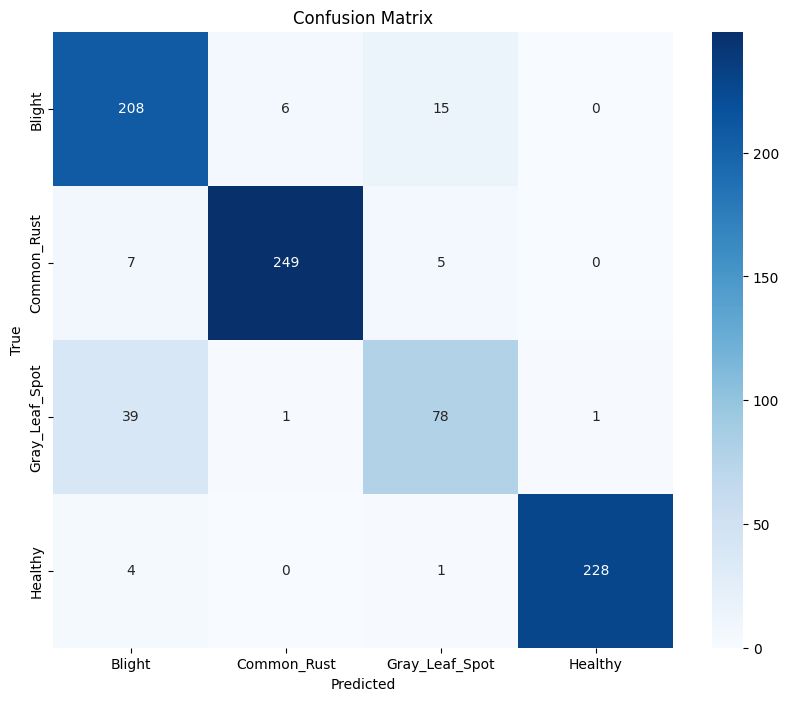

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Classification Report
print("Classification Report:\n", classification_report(test_labels, y_pred, target_names=le.classes_))

Classification Report:
                 precision    recall  f1-score   support

        Blight       0.81      0.91      0.85       229
   Common_Rust       0.97      0.95      0.96       261
Gray_Leaf_Spot       0.79      0.66      0.72       119
       Healthy       1.00      0.98      0.99       233

      accuracy                           0.91       842
     macro avg       0.89      0.87      0.88       842
  weighted avg       0.91      0.91      0.91       842



Making Predictions and Displaying Resultsg

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Generate predictions for the test set
y_pred_probs = model.predict(test_ds)  # Probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class labels


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step


In [ ]:
# Sample a few test images for display with their actual and predicted labels
test_images = []
test_labels_disp = []
predicted_labels_disp = []

In [ ]:
# Loop through a small sample of test images
for img, label in test_ds.take(5):  # Display 5 batches of test images
    test_images.extend(img.numpy())  # Add images to list
    test_labels_disp.extend(label.numpy())  # Add true labels to list
    predicted_labels_disp.extend(y_pred[:len(label)])  # Add predicted labels to list
    y_pred = y_pred[len(label):]  # Update remaining predictions


In [ ]:
# Define a function to display images with actual and predicted labels
def plot_predictions(images, true_labels, predicted_labels, class_names):
    plt.figure(figsize=(12, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)  # Display in a 3x3 grid
        plt.imshow(images[i])
        true_class = class_names[true_labels[i]]
        pred_class = class_names[predicted_labels[i]]
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=("green" if true_class == pred_class else "red"))
        plt.axis("off")
    plt.tight_layout()
    plt.show()


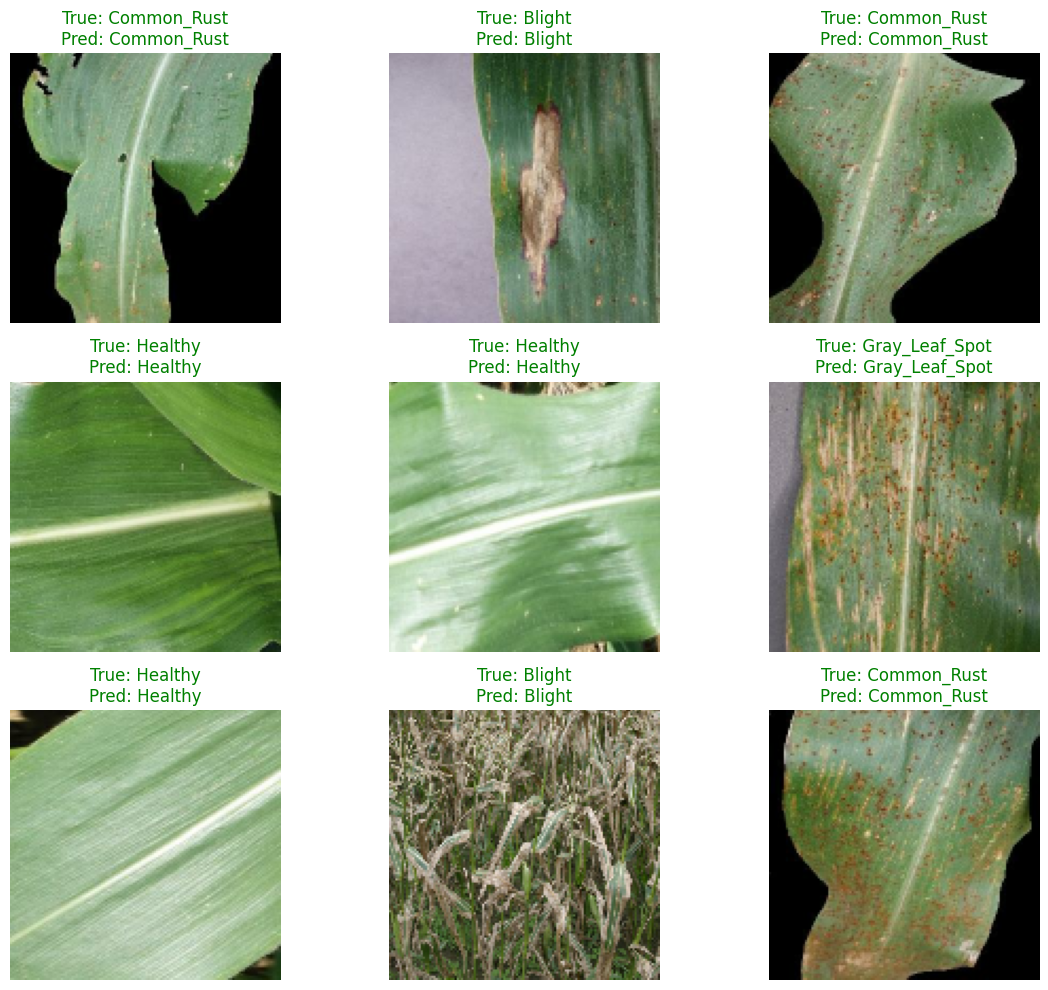

In [ ]:
# Plotting sample predictions
plot_predictions(test_images[:9], test_labels_disp[:9], predicted_labels_disp[:9], le.classes_)

Plotting the Model’s Training History

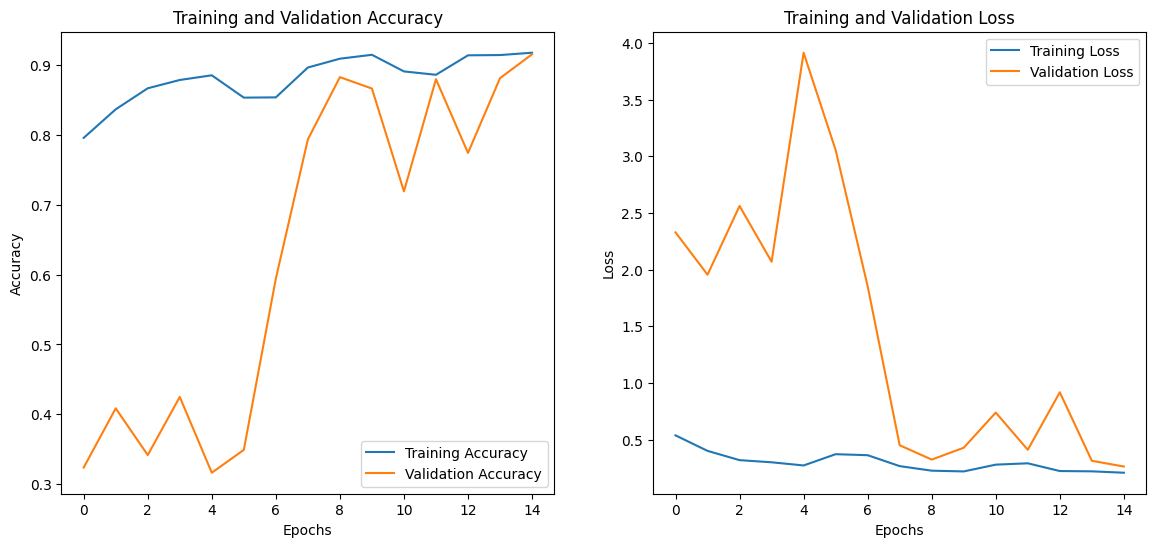

In [ ]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(14, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()